## Analysis of the topics created by the Top2Vec model

- Primitives are loaded, as well as the topic weights of the reduced top2vec model (100 topics) --> see part II in `top2vec_training.ipynb`.
- They are merged into one df.
- Topics are plotted over time in bins per year, using `agg.('mean')`.
- 



In [57]:
import ndjson
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn-whitegrid')
from scipy.ndimage import gaussian_filter1d
import tslearn
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


### Load primitives with corrected date and topic weights and merge both

In [2]:
# import primitives with corrected date and topic weights
with open('../../corpus/primitives_220331/events_repre_reduced.ndjson') as f:
    events = ndjson.load(f)

df_events = pd.DataFrame(events)
df_events.shape

# remove primitives that have no topic weights (shorter than 50 characters)
df_events.dropna(subset=['representation'], inplace=True)

# transpose representations to 100 separate columns
representations = pd.DataFrame(df_events.representation.to_list(), index = df_events.index)

# merge events and representations and save to csv
total = pd.merge(left=df_events, right=representations, left_index=True, right_index=True).drop(columns='representation')
total.to_csv('/work/62138/corpus/total.csv')

(22721, 7)

### Plot dominant topics over time

/tmp/ipykernel_271/2401015562.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total.groupby('year')[0, 1, 2, 3, 4].agg('mean').rolling(window=5).mean().plot()


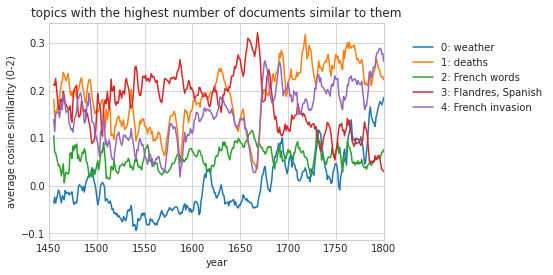

In [7]:
total.groupby('year')[0, 1, 2, 3, 4].agg('mean').rolling(window=5).mean().plot()
plt.legend(['0: weather', '1: deaths', '2: French words', '3: Flandres, Spanish', '4: French invasion'], loc='right', bbox_to_anchor=(1.5, 0.75))
plt.title('topics with the highest number of documents similar to them')
plt.ylabel('average cosine similarity (0-2)')
plt.xlabel('year')
plt.xlim([1450, 1800])
plt.show()

/tmp/ipykernel_271/1312611065.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total.groupby('year')[11, 41, 32, 20, 96].agg('mean').plot()


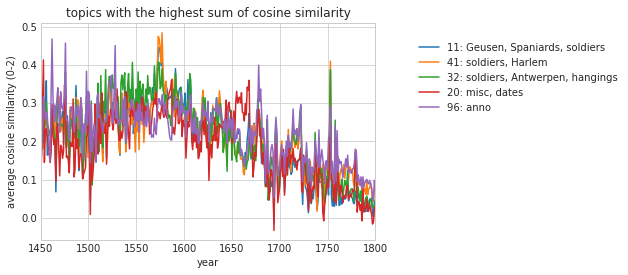

In [8]:
total.groupby('year')[11, 41, 32, 20, 96].agg('mean').plot()
# rolling(window=5).mean().plot()
plt.legend(['11: Geusen, Spaniards, soldiers', '41: soldiers, Harlem', '32: soldiers, Antwerpen, hangings', '20: misc, dates', '96: anno'], loc='right', bbox_to_anchor=(1.75, 0.75))
plt.title('topics with the highest sum of cosine similarity')
plt.ylabel('average cosine similarity (0-2)')
plt.xlabel('year')
plt.xlim([1450, 1800])
plt.show()

### Observations

- Difference between *topics with high number of documents similar to them* and *topics with high number of cosine similarity*
- What methods can we use to smoothen the signal?
    - `rolling(window).mean()` takes subsequent data points and averages them, but will give weird output when there are large time gaps between two data points.
    - `scipy.ndimage.gaussian_filter1d`, sigma = 2.

### Scaling and smoothening

- We use the original representations of the cosine similarity, ranging from -1 to +1.
- We apply the `TimeSeriesScalerMeanVariance` in `tslearn.preprocessing`.

In [10]:
total['year'] = total['clean_date'].str[:4]
total['year'] = pd.to_numeric(total['year'])
total = total[(total['year'] >= 1450) & (total['year'] <=1800)]

columns = list(range(0,100))
year_mean = total.groupby('year')[columns].agg('mean').reset_index()
year_mean_scaled = year_mean.copy().drop(columns=columns)

for column in year_mean.iloc[:, 1:101]:
    scaled = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform([year_mean[column].values])
    year_mean_scaled[column] = scaled[0].flatten().tolist()

year_mean.to_csv('/work/62138/corpus/year_mean.csv')
year_mean_scaled.to_csv('/work/62138/corpus/year_mean_scaled.csv')

In [2]:
year_mean_scaled = pd.read_csv('../../chronicling-topics/corpus/dfs_topics/year_mean_scaled.csv', index_col=0)
year_mean_scaled.head()

,year,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1450,-0.272212,1.581187,5.687352,0.470106,1.219626,0.878718,-0.359234,1.503809,2.211649,...,1.360070,0.538550,3.852131,1.723419,-2.332223,1.688561,0.957550,-0.346109,3.647183,1.105196
1,1451,-0.299907,-1.138443,-1.145044,-0.750547,-1.927901,-0.943105,-1.523076,-1.130025,-1.127321,...,-0.186829,-1.938838,-1.518069,0.062274,1.138678,-0.858984,-0.831873,-1.577613,-1.783913,-1.235959
2,1453,-1.630772,-1.292714,1.808157,3.052558,-1.600364,-1.608338,-1.433308,0.611399,1.718354,...,-0.486289,-0.409831,0.822390,1.545176,0.588994,1.384890,1.244834,-1.571017,-0.050993,-1.580335
3,1454,0.346062,0.435455,-0.188963,-0.313646,1.754227,0.215970,0.276811,0.641815,-0.066323,...,0.785294,4.545936,-0.611967,-1.099752,-1.183042,0.165667,0.843971,0.082539,-0.017649,0.562937
4,1455,-0.841500,-0.006961,-0.354175,0.427795,-0.116554,-0.879924,-0.586642,-0.101221,1.314314,...,-0.069171,2.076482,-0.092437,0.179779,-1.078278,0.474620,0.429645,-0.241994,-0.579078,-0.509721


Text(0, 0.5, 'scaled mean cosine similarity')

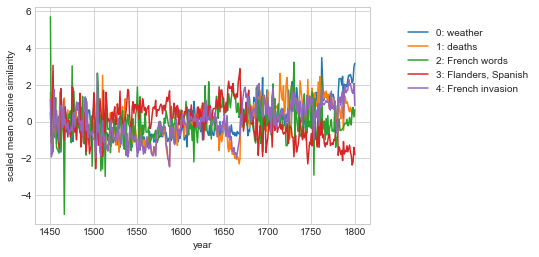

In [26]:
year_mean_scaled.plot(x='year', y=['0', '1', '2', '3', '4'])
plt.legend(['0: weather', '1: deaths', '2: French words', '3: Flanders, Spanish', '4: French invasion'],
loc='right', bbox_to_anchor=(1.5, 0.75))
plt.xlabel('year')
plt.ylabel('scaled mean cosine similarity')

### Smoothening with a Gaussian kernel

/Users/alielassche/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/alielassche/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


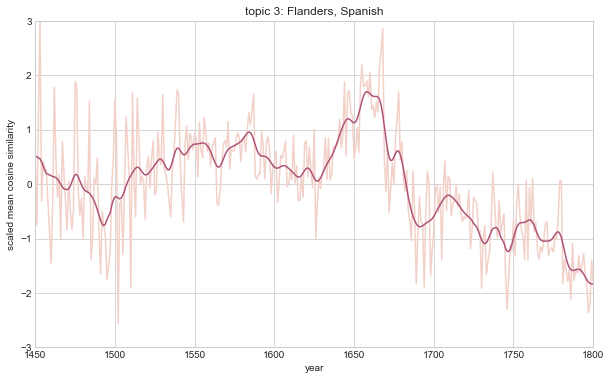

In [58]:
#fig, (axes) = plt.subplots(3, 1, figsize=(4, 12), sharey=False)

topic = ['0', '1', '2', '3', '4', '5'] # topic number to be smoothened with the gaussian filter and plotted

smooth = gaussian_filter1d(year_mean_scaled[topic[3]].to_numpy(), 3)
plt.figure(figsize=(10, 6))
sns.lineplot(year_mean_scaled['year'], year_mean_scaled[topic[3]], color='#F2D1C9')
sns.lineplot(year_mean_scaled['year'], smooth, color='#AE5377')
plt.title('topic 3: Flanders, Spanish')
plt.xlabel('year')
plt.ylabel('scaled mean cosine similarity')
plt.xlim([1450, 1800])
plt.ylim([-3, +3])
plt.show()

/Users/alielassche/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/alielassche/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-3, 3)

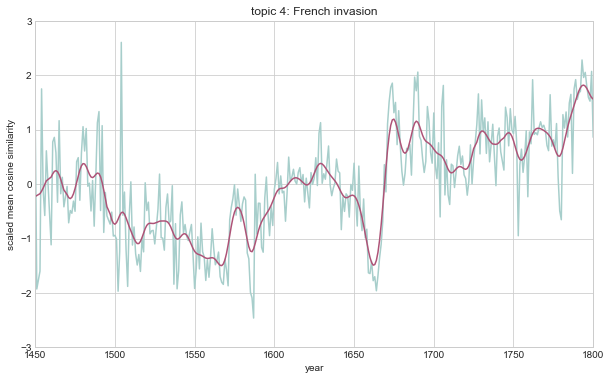

In [59]:
plt.figure(figsize=(10, 6))
smooth = gaussian_filter1d(year_mean_scaled[topic[4]].to_numpy(), 3)
sns.lineplot(year_mean_scaled['year'], year_mean_scaled[topic[4]], color='#A7CECB')
sns.lineplot(year_mean_scaled['year'], smooth, color='#AE5377')
plt.title('topic 4: French invasion')
plt.xlabel('year')
plt.ylabel('scaled mean cosine similarity')
plt.xlim([1450, 1800])
plt.ylim([-3, +3])